In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import datetime
import geocoder
import geopandas as gpd
from glob import glob
import os
%matplotlib inline
ox.config(log_console=True, use_cache=True)

In [2]:
def get_time(t1, t2):
    
    diff = t2 - t1
    
    c = round(diff.total_seconds() / 60, 2)
    
    return c

In [3]:
def get_graph_old(place):
    string = place.split(',')[0]
    
    print('Fetching graph data for {}'.format(place))
    # download and project a street network
    if not place == 'Monrovia, Liberia':
        try:
            G = ox.graph_from_place(place, network_type='drive')
        except TypeError:
            try:
                G = ox.graph_from_place(place, network_type='drive', which_result=2)
            except TypeError:
                geo = geocoder.osm(place)
                lon = geo.geojson['features'][0]['properties']['lng']
                lat = geo.geojson['features'][0]['properties']['lng']
                G = ox.graph_from_point(center_point=( lon, lat), distance = 20000)
            except KeyError:
                geo = geocoder.osm(place)
                lon = geo.geojson['features'][0]['properties']['lng']
                lat = geo.geojson['features'][0]['properties']['lng']
                G = ox.graph_from_point(center_point=( lon, lat), distance = 20000)
        except:
            geo = geocoder.osm(place)
            lon = geo.geojson['features'][0]['properties']['lng']
            lat = geo.geojson['features'][0]['properties']['lng']
            G = ox.graph_from_point(center_point=( lon, lat), distance = 20000)
    else:
        adm3 = gpd.GeoDataFrame.from_file('Liberia/LBR_adm3.shp')
        mnv = adm3[adm3.NAME_3 == 'Monrovia'].geometry.values[0]
        G = ox.graph_from_polygon(mnv, network_type='drive')
        
    G = ox.project_graph(G)
    
    print('Writing graph file')
    
    try:
        os.mkdir('data/{}'.format(string))
    except FileExistsError:
        pass
    
    nx.write_gpickle(G, path='data/{a}/{a}'.format(a=string))
    
    return G

In [4]:
def get_polygon(string):
    
    lis = glob('/nfshome/gb1877/gb1877/WorldBank/CRP/Betweenness_Centrality/data/AOI/*/*.shp')
    
    city = []
    for i in lis:
        x = i.split('/')[-2]
        city.append(x.split('_')[0])
        
    if string in city:
        l = glob('/nfshome/gb1877/gb1877/WorldBank/CRP/Betweenness_Centrality/data/AOI/{}_AOI/*.shp'.format(string))
        adm = gpd.GeoDataFrame.from_file(l[0])
        boundary_poly = adm.geometry.values[0]
    else:
        boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=1)
        boundary_poly = boundary_GDF.loc[0,'geometry']
        if boundary_poly.geom_type == 'Polygon':
            boundary_poly = boundary_poly
        else:
            try:
                boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=2)
                boundary_poly = boundary_GDF.loc[0,'geometry']
            except:
                print('Polygon not available')
    
    return boundary_poly

In [5]:
def get_graph(place):
    string = place.split(',')[0]
    
    print('Fetching graph data for {}'.format(place))

    G = ox.graph_from_polygon(get_polygon(string), network_type='drive')
    
    G = ox.project_graph(G)
    
    print('Writing graph file')
    
    try:
        os.mkdir('data/{}'.format(string))
    except FileExistsError:
        pass
    
    nx.write_gpickle(G, path='data/{a}/{a}'.format(a=string))
    
    return G

In [6]:
def get_edge_centrality(place):
    
    t1 = datetime.datetime.now()
    
    string = place.split(',')[0]
    
    # download and project a street network
    
    G = get_graph(place)
    #G = ox.graph_from_place('Davao City, Philippines')
    t2 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t2)))
    
    print('Getting node centrality')
    #node_centrality = nx.betweenness_centrality(G)
    
    
    t3 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t3)))
    
    print('Getting edge centrality')
    # edge closeness centrality: convert graph to a line graph so edges become nodes and vice versa
    edge_centrality = nx.edge_betweenness_centrality(G)
    
    t4 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t4)))
    
    new_edge_centrality = {}

    for u,v in edge_centrality:
        new_edge_centrality[(u,v,0)] = edge_centrality[u,v]
    
    print('Saving output gdf')
    
    #nx.set_node_attributes(G, node_centrality, 'node_centrality')
    nx.set_edge_attributes(G, new_edge_centrality, 'edge_centrality')
    ox.save_graph_shapefile(G, filename='{}'.format(string))
    
    t5 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t5)))
    
    print('Getting extended stats')
    
    #extended_stats = ox.extended_stats(G, bc=True)
    
    #dat = pd.DataFrame.from_dict(extended_stats)
    #dat.to_csv('data/{a}/Extended_Stats_{b}.csv'.format(a=string, b=string))
    
    t6 = datetime.datetime.now()
    
    print('{} minutes elapsed!'.format(get_time(t1, t6)))
    
    print('Getting basic stats')
    
    basic_stats = ox.basic_stats(G)
    dat = pd.DataFrame.from_dict(basic_stats)
    dat.to_csv('data/{a}/Basic_Stats_{b}.csv'.format(a=string, b=string))
    
    return

1. Sfax, Tunisia
2. Sousse, Tunisia
3. Tunis, Tunisia
4. Batroun, Lebanon
5. Bint Jbeil, Lebanon
6. Joub Jannine, Lebanon
7. West Bank
8. Montevideo, Uruguay
9. Lima, Peru
10. Cap-Haitien, Haiti
11. Vinh Long, Vietnam
12. Khan Hoa, Vietnam
13. Semarang, Indonesia
14. Penang, Malaysia
15. Tashkent, Uzbekistan
16. Osh, Kyrgyz 
17. Turkey (city TBD)
18. Monrovia, Liberia 
19. Johannesburg, South Africa
20. Maputo, Mozambique 
21. Addis Ababa, Ethiopia 
22. Blantyr, Malawi
23. St. Louis, Senegal (TBC)
24. Cotonou, Benin (TBC)
25. Accra, Ghana (TBC)
26. Province of Palawan, Philippines
27. Davao City, Philippines

In [6]:
city_scan_list = [
    'Sfax, Tunisia',
'Sousse, Tunisia',
'Tunis, Tunisia',
'Batroun, Lebanon',
'Bint Jbeil, Lebanon',
'Joub Jannine, Lebanon',
#'West Bank', 
'Montevideo, Uruguay',
'Lima, Peru',
'Cap-Haitien, Haiti',
'Vinh Long, Vietnam',
'Khanh Hoa, Vietnam',
'Semarang, Indonesia',
'Penang, Malaysia',
'Tashkent, Uzbekistan',
'Osh,  Kyrgyzstan',
#Turkey (city TBD)
'Monrovia, Liberia',
'Johannesburg, South Africa',
'Maputo, Mozambique',
'Addis Ababa, Ethiopia',
'Blantyr, Malawi',
'St. Louis, Senegal',
'Cotonou, Benin',
'Accra, Ghana',
'Province of Palawan, Philippines',
'Davao City, Philippines'
    
]

In [ ]:
for i in city_scan_list[13:]:
    %time get_edge_centrality(i)

Fetching graph data for Tashkent, Uzbekistan
Writing graph file
1.23 minutes elapsed!
Getting node centrality
25.49 minutes elapsed!
Getting edge centrality


In [5]:
problem_cities = ['Bint Jbeil, Lebanon',
'Joub Jannine, Lebanon','Khanh Hoa, Vietnam','Semarang, Indonesia',
'Penang, Malaysia','Monrovia, Liberia','Johannesburg, South Africa',
                 'Addis Ababa, Ethiopia','Blantyr, Malawi','St. Louis, Senegal',
                  'Cotonou, Benin', 'Accra, Ghana',]

In [13]:
%time get_edge_centrality('Davao City, Philippines')

Fetching graph data for Davao City, Philippines
Writing graph file
0.02 minutes elapsed!
Getting node centrality
0.02 minutes elapsed!
Getting edge centrality
0.02 minutes elapsed!
Saving output gdf


/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


0.03 minutes elapsed!
Getting extended stats
0.03 minutes elapsed!
Getting basic stats
CPU times: user 1.74 s, sys: 28 ms, total: 1.77 s
Wall time: 1.94 s


In [12]:
%time get_edge_centrality('Lima, Peru')

Fetching graph data for Lima, Peru
Writing graph file
1.04 minutes elapsed!
Getting node centrality
1.53 minutes elapsed!
Getting edge centrality
4.96 minutes elapsed!
Saving output gdf
5.08 minutes elapsed!
Getting extended stats
6.23 minutes elapsed!
Getting basic stats
CPU times: user 5min 24s, sys: 1.08 s, total: 5min 25s
Wall time: 6min 14s


In [22]:
%time get_edge_centrality('Monrovia, Liberia')

Fetching graph data for Monrovia, Liberia
Writing graph file
0.93 minutes elapsed!
Getting node centrality
4.27 minutes elapsed!
Getting edge centrality
30.46 minutes elapsed!
Saving output gdf


/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


30.75 minutes elapsed!
Getting extended stats
37.97 minutes elapsed!
Getting basic stats
CPU times: user 37min 35s, sys: 932 ms, total: 37min 36s
Wall time: 38min 2s


In [ ]:
%time get_edge_centrality('West Bank')

Fetching graph data for West Bank
Writing graph file
42.15 minutes elapsed!
Getting node centrality


### Priority cities

- El Nido, Philippines
- Coron, Philippines 
- Puerto Princesa, Philippines
- Davao City, Philippines
- Tashkent, Uzbekistan
- West Bank
- Lima, Peru
- Vinh Long, Vietnam
- Khan Hoa, Vietnam
- Osh, Kyrgyz
- Monrovia, Liberia


In [31]:
city

['Puerto Princesa',
 'West Bank',
 'Davao',
 'Coron',
 'Khan Hoa',
 'Bethlehem',
 'Monrovia',
 'Hebron',
 'Osh',
 'El Nido',
 'Lima',
 'Tashkent',
 'Penang',
 'Vinh Long']

In [ ]:
for i in city:
    %time get_edge_centrality(i)

Fetching graph data for Puerto Princesa
Writing graph file
0.32 minutes elapsed!
Getting node centrality
1.33 minutes elapsed!
Getting edge centrality
10.92 minutes elapsed!
Saving output gdf


/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


11.07 minutes elapsed!
Getting extended stats
13.36 minutes elapsed!
Getting basic stats
CPU times: user 13min 14s, sys: 720 ms, total: 13min 15s
Wall time: 13min 21s
Fetching graph data for West Bank
Writing graph file
0.93 minutes elapsed!
Getting node centrality
8.34 minutes elapsed!
Getting edge centrality
86.47 minutes elapsed!
Saving output gdf


86.86 minutes elapsed!
Getting extended stats
103.25 minutes elapsed!
Getting basic stats
CPU times: user 1h 43min 12s, sys: 1.96 s, total: 1h 43min 14s
Wall time: 1h 43min 16s
Fetching graph data for Davao
Writing graph file
0.54 minutes elapsed!
Getting node centrality
3.88 minutes elapsed!
Getting edge centrality
36.33 minutes elapsed!
Saving output gdf


36.59 minutes elapsed!
Getting extended stats
43.97 minutes elapsed!
Getting basic stats
CPU times: user 43min 55s, sys: 1.16 s, total: 43min 56s
Wall time: 43min 58s
Fetching graph data for Coron
Writing graph file
0.03 minutes elapsed!
Getting node centrality
0.03 minutes elapsed!
Getting edge centrality


0.03 minutes elapsed!
Saving output gdf


0.04 minutes elapsed!
Getting extended stats
0.04 minutes elapsed!
Getting basic stats
CPU times: user 1.51 s, sys: 4 ms, total: 1.51 s
Wall time: 2.53 s
Fetching graph data for Khan Hoa
Writing graph file
1.07 minutes elapsed!
Getting node centrality
5.12 minutes elapsed!
Getting edge centrality
44.68 minutes elapsed!
Saving output gdf


45.0 minutes elapsed!
Getting extended stats
54.33 minutes elapsed!
Getting basic stats
CPU times: user 54min 10s, sys: 1.69 s, total: 54min 12s
Wall time: 54min 21s
Fetching graph data for Bethlehem
Writing graph file
0.91 minutes elapsed!
Getting node centrality
2.25 minutes elapsed!
Getting edge centrality
10.65 minutes elapsed!
Saving output gdf


10.81 minutes elapsed!
Getting extended stats
13.37 minutes elapsed!
Getting basic stats
CPU times: user 13min 21s, sys: 1.06 s, total: 13min 22s
Wall time: 13min 23s
Fetching graph data for Monrovia
Writing graph file
1.05 minutes elapsed!
Getting node centrality
8.29 minutes elapsed!
Getting edge centrality
59.8 minutes elapsed!
Saving output gdf


60.12 minutes elapsed!
Getting extended stats
73.85 minutes elapsed!
Getting basic stats
CPU times: user 1h 13min 49s, sys: 1.98 s, total: 1h 13min 51s
Wall time: 1h 13min 52s
Fetching graph data for Hebron
Writing graph file
4.36 minutes elapsed!
Getting node centrality


In [8]:
%time get_edge_centrality('Tashkent, Uzbekistan')

Fetching graph data for Tashkent, Uzbekistan
Writing graph file
1.33 minutes elapsed!
Getting node centrality
25.43 minutes elapsed!
Getting edge centrality
235.26 minutes elapsed!
Saving output gdf


/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


235.99 minutes elapsed!
Getting extended stats
292.0 minutes elapsed!
Getting basic stats
CPU times: user 4h 51min 34s, sys: 11.6 s, total: 4h 51min 45s
Wall time: 4h 52min 2s


In [9]:
%time get_edge_centrality('Vinh Long, Vietnam')

Fetching graph data for Vinh Long, Vietnam
Writing graph file
0.06 minutes elapsed!
Getting node centrality
0.09 minutes elapsed!
Getting edge centrality
0.41 minutes elapsed!
Saving output gdf
0.45 minutes elapsed!
Getting extended stats
0.54 minutes elapsed!
Getting basic stats
CPU times: user 30.8 s, sys: 144 ms, total: 30.9 s
Wall time: 32.2 s


In [ ]:
%time get_edge_centrality('Lima, Peru')

Fetching graph data for Lima, Peru
Writing graph file
12.29 minutes elapsed!
Getting node centrality


In [18]:
G_ = nx.read_gpickle('data/Maputo/Maputo')

In [ ]:
%time edge_centrality = nx.betweenness_centrality(nx.line_graph(G_))

In [22]:
nx.set_edge_attributes(G_, edge_centrality, 'edge_centrality')
ox.save_graph_shapefile(G_, filename='{}'.format('Maputo'))

/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [4]:
G = nx.read_gpickle('data/Penang/Penang.gpickle')

In [5]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

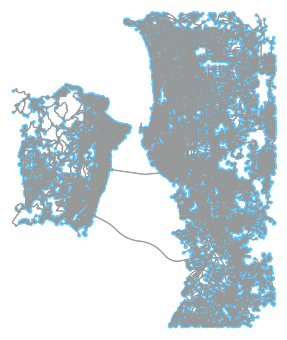

(<Figure size 352.242x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07a064aa20>)

In [6]:
ox.plot_graph(G)

In [ ]:
%%time 
edge_centrality = nx.betweenness_centrality(nx.line_graph(G))

In [ ]:
%time ec = nx.edge_betweenness_centrality(G)

In [10]:
n = ox.graph_to_gdfs(G, nodes=False, edges = True)

In [11]:
n. head()

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,LINESTRING (653305.5574910371 607304.237032867...,residential,NaN,0,NaN,117.465,NaN,NaN,False,160842035,NaN,NaN,NaN,1728577536,1728577542,NaN
1,NaN,NaN,LINESTRING (653305.5574910371 607304.237032867...,tertiary,NaN,0,NaN,26.812,NaN,NaN,False,160842253,NaN,NaN,NaN,1728577536,6039343375,NaN
2,NaN,NaN,LINESTRING (653305.5574910371 607304.237032867...,tertiary,NaN,0,NaN,22.836,NaN,NaN,False,160842253,NaN,NaN,NaN,1728577536,1728577537,NaN
3,NaN,NaN,LINESTRING (653305.5574910371 607304.237032867...,residential,NaN,0,NaN,17.772,NaN,NaN,False,160842260,NaN,NaN,NaN,1728577536,1728577531,NaN
4,NaN,NaN,LINESTRING (653328.3562943337 607305.893061060...,tertiary,NaN,0,NaN,22.836,NaN,NaN,False,160842253,NaN,NaN,NaN,1728577537,1728577536,NaN


In [16]:
n.geometry.geom_type.unique()

array(['LineString'], dtype=object)

In [75]:
p = nx.read_gpickle('data/Penang/Penang.gpickle')

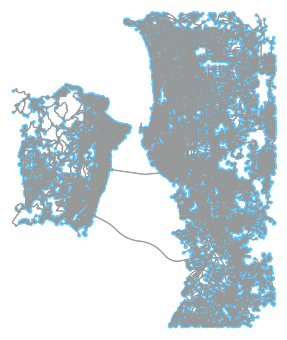

(<Figure size 352.242x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fddecee4080>)

In [76]:
ox.plot_graph(p)

In [ ]:
%time edge_centrality__ = nx.edge_betweenness_centrality(p)

In [78]:
edge_centrality__

{(1728577536, 1728577542): 0.00020222177181521855,
 (1728577536, 6039343375): 0.00023912226595279451,
 (1728577536, 1728577537): 0.00043201701040732933,
 (1728577536, 1728577531): 7.191211309166181e-05,
 (1728577537, 1728577536): 0.0005218994863871556,
 (1728577537, 6039343745): 0.00013134412304812538,
 (1728577537, 4806220561): 0.0004022029572414075,
 (1728577539, 1728577535): 8.651720950817094e-05,
 (1728577539, 6039343642): 5.164909109411773e-06,
 (1728577539, 6039343648): 7.979660264008269e-05,
 (1735972928, 5721679716): 2.9481348333989113e-06,
 (1735972928, 5721679718): 2.064299070048485e-05,
 (1735972928, 5508320705): 8.843052770821731e-06,
 (6010175493, 6010175470): 8.843052770821731e-06,
 (6010175493, 6010175469): 8.154980742636131e-05,
 (6010175493, 3832474694): 0.00010426130315203338,
 (1728577542, 1728577557): 9.333675947521067e-05,
 (1728577542, 1728577536): 0.00015675725954655045,
 (1728577542, 6039343373): 0.00010020589109762118,
 (1728577541, 6039343373): 7.4113500744553

In [79]:
%%time
new_edge_centrality = {}

for u,v in edge_centrality__:
    new_edge_centrality[(u,v,0)] = edge_centrality__[u,v]

CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 294 ms


In [81]:
len(new_edge_centrality)

272246

In [82]:
nx.set_edge_attributes(p, new_edge_centrality, 'edge_centrality')
ox.save_graph_shapefile(p, filename='{}'.format('Penang'))

/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## Phase 2 Cities

In [9]:
phase2_list = ['Bethlehem, West Bank',
'Hebron, West Bank',
'Lima, Peru', #– metropolitan area
'Vinh Long, Vietnam',
'Khan Hoa, Vietnam', #– focused on the districts of Nha Trang, Cam Ranh, Ninh Hoa and Van Ninh
'Semarang, Indonesia',
'Osh, Kyrgyz',
'Sfax, Tunisia',
'Sousse, Tunisia',
'Tunis, Tunisia',
'Batroun, Lebanon',
'Bint Jbeil, Lebanon',
'Montevideo, Uruguay',
'Cap-Haitien, Haiti',
'Porto Alegre, Brazil', #– focused on the 4th district
'Ibadan, Nigeria',
'Mogadishu, Somalia',
'Garowe, Somalia ',
'Monrovia, Liberia',
"Abidjan, Cote d’Ivoire",
'Blantyre, Malawi']

In [ ]:
for i in phase2_list:
    %time get_edge_centrality(i)

Fetching graph data for Bethlehem, West Bank
Writing graph file
0.94 minutes elapsed!
Getting node centrality
0.94 minutes elapsed!
Getting edge centrality
2.5 minutes elapsed!
Saving output gdf


/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


2.67 minutes elapsed!
Getting extended stats
2.67 minutes elapsed!
Getting basic stats
CPU times: user 2min 41s, sys: 1.37 s, total: 2min 43s
Wall time: 2min 40s
Fetching graph data for Hebron, West Bank
Writing graph file
3.91 minutes elapsed!
Getting node centrality
3.91 minutes elapsed!
Getting edge centrality
44.67 minutes elapsed!
Saving output gdf
45.49 minutes elapsed!
Getting extended stats
45.49 minutes elapsed!
Getting basic stats
CPU times: user 44min 29s, sys: 3.9 s, total: 44min 33s
Wall time: 45min 33s
Fetching graph data for Lima, Peru
Writing graph file
13.43 minutes elapsed!
Getting node centrality
13.43 minutes elapsed!
Getting edge centrality


KeyboardInterrupt: 

Fetching graph data for Vinh Long, Vietnam
Writing graph file
0.05 minutes elapsed!
Getting node centrality
0.05 minutes elapsed!
Getting edge centrality
0.1 minutes elapsed!
Saving output gdf
0.13 minutes elapsed!
Getting extended stats
0.13 minutes elapsed!
Getting basic stats
CPU times: user 6.8 s, sys: 112 ms, total: 6.91 s
Wall time: 7.88 s
Fetching graph data for Khan Hoa, Vietnam


TypeError: Geometry must be a shapely Polygon or MultiPolygon. If you requested graph from place name or address, make sure your query resolves to a Polygon or MultiPolygon, and not some other geometry, like a Point. See OSMnx documentation for details.

Fetching graph data for Semarang, Indonesia
Writing graph file
6.75 minutes elapsed!
Getting node centrality
6.75 minutes elapsed!
Getting edge centrality
268.87 minutes elapsed!
Saving output gdf
271.01 minutes elapsed!
Getting extended stats
271.01 minutes elapsed!
Getting basic stats
CPU times: user 4h 30min 49s, sys: 19.5 s, total: 4h 31min 8s
Wall time: 4h 31min 8s
Fetching graph data for Osh, Kyrgyz
Writing graph file
0.34 minutes elapsed!
Getting node centrality
0.34 minutes elapsed!
Getting edge centrality
2.43 minutes elapsed!
Saving output gdf
2.63 minutes elapsed!
Getting extended stats
2.63 minutes elapsed!
Getting basic stats
CPU times: user 2min 38s, sys: 1.35 s, total: 2min 39s
Wall time: 2min 38s
Fetching graph data for Sfax, Tunisia
Writing graph file
0.57 minutes elapsed!
Getting node centrality
0.57 minutes elapsed!
Getting edge centrality
3.43 minutes elapsed!
Saving output gdf
3.64 minutes elapsed!
Getting extended stats
3.64 minutes elapsed!
Getting basic stats
CP

In [10]:
for i in phase2_list[10:]:
    %time get_edge_centrality(i)

Fetching graph data for Batroun, Lebanon
Writing graph file
0.05 minutes elapsed!
Getting node centrality
0.05 minutes elapsed!
Getting edge centrality
0.06 minutes elapsed!
Saving output gdf
0.08 minutes elapsed!
Getting extended stats
0.08 minutes elapsed!
Getting basic stats
CPU times: user 4.5 s, sys: 36 ms, total: 4.54 s
Wall time: 4.59 s
Fetching graph data for Bint Jbeil, Lebanon
Polygon not available


TypeError: Geometry must be a shapely Polygon or MultiPolygon. If you requested graph from place name or address, make sure your query resolves to a Polygon or MultiPolygon, and not some other geometry, like a Point. See OSMnx documentation for details.

Fetching graph data for Montevideo, Uruguay
Writing graph file
1.49 minutes elapsed!
Getting node centrality
1.49 minutes elapsed!
Getting edge centrality
35.02 minutes elapsed!
Saving output gdf
35.92 minutes elapsed!
Getting extended stats
35.92 minutes elapsed!
Getting basic stats
CPU times: user 35min 53s, sys: 8.63 s, total: 36min 2s
Wall time: 35min 58s
Fetching graph data for Cap-Haitien, Haiti
Writing graph file
0.11 minutes elapsed!
Getting node centrality
0.11 minutes elapsed!
Getting edge centrality
0.35 minutes elapsed!
Saving output gdf
0.43 minutes elapsed!
Getting extended stats
0.43 minutes elapsed!
Getting basic stats
CPU times: user 25.7 s, sys: 224 ms, total: 25.9 s
Wall time: 25.7 s
Fetching graph data for Porto Alegre, Brazil
Writing graph file
1.24 minutes elapsed!
Getting node centrality
1.24 minutes elapsed!
Getting edge centrality
36.74 minutes elapsed!
Saving output gdf
37.53 minutes elapsed!
Getting extended stats
37.53 minutes elapsed!
Getting basic stats
CP

TypeError: Geometry must be a shapely Polygon or MultiPolygon. If you requested graph from place name or address, make sure your query resolves to a Polygon or MultiPolygon, and not some other geometry, like a Point. See OSMnx documentation for details.

Fetching graph data for Mogadishu, Somalia
Polygon not available


TypeError: Geometry must be a shapely Polygon or MultiPolygon. If you requested graph from place name or address, make sure your query resolves to a Polygon or MultiPolygon, and not some other geometry, like a Point. See OSMnx documentation for details.

Fetching graph data for Garowe, Somalia 


TypeError: Geometry must be a shapely Polygon or MultiPolygon. If you requested graph from place name or address, make sure your query resolves to a Polygon or MultiPolygon, and not some other geometry, like a Point. See OSMnx documentation for details.

Fetching graph data for Monrovia, Liberia
Writing graph file
0.93 minutes elapsed!
Getting node centrality
0.93 minutes elapsed!
Getting edge centrality
7.25 minutes elapsed!
Saving output gdf
7.57 minutes elapsed!
Getting extended stats
7.57 minutes elapsed!
Getting basic stats
CPU times: user 7min 36s, sys: 1.2 s, total: 7min 37s
Wall time: 7min 35s
Fetching graph data for Abidjan, Cote d’Ivoire
Writing graph file
8.36 minutes elapsed!
Getting node centrality
8.36 minutes elapsed!
Getting edge centrality
208.08 minutes elapsed!
Saving output gdf
209.92 minutes elapsed!
Getting extended stats
209.92 minutes elapsed!
Getting basic stats
CPU times: user 3h 29min 53s, sys: 11.3 s, total: 3h 30min 4s
Wall time: 3h 30min 1s
Fetching graph data for Blantyre, Malawi


TypeError: Geometry must be a shapely Polygon or MultiPolygon. If you requested graph from place name or address, make sure your query resolves to a Polygon or MultiPolygon, and not some other geometry, like a Point. See OSMnx documentation for details.

## Lima

In [14]:
#G = nx.read_gpickle('data/Lima/Lima')

%time edge_centrality = nx.edge_betweenness_centrality(G)

CPU times: user 1d 16h 28min 7s, sys: 21.6 s, total: 1d 16h 28min 29s
Wall time: 1d 16h 28min 9s


In [15]:
new_edge_centrality = {}

for u,v in edge_centrality:
    new_edge_centrality[(u,v,0)] = edge_centrality[u,v]

print('Saving output gdf')

#nx.set_node_attributes(G, node_centrality, 'node_centrality')
%time nx.set_edge_attributes(G, new_edge_centrality, 'edge_centrality')
ox.save_graph_shapefile(G, filename='{}'.format('Lima'))

Saving output gdf
CPU times: user 856 ms, sys: 4 ms, total: 860 ms
Wall time: 856 ms


/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [23]:
basic_stats = ox.basic_stats(G)
dat = pd.DataFrame.from_dict(basic_stats)
dat.to_csv('data/{a}/Basic_Stats_{b}.csv'.format(a='Lima', b='Lima'))

In [16]:
gp = gpd.read_file('data/Lima/edges/edges.shp')

In [17]:
gp.head()

,access,bridge,edge_centr,from,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,None,None,0.00010904355843800482,273413466,residential,None,0,None,56.041,None,Rio Rimac,False,428031671,None,None,1738539013,None,None,LINESTRING (283500.4928064455 -1331334.1747018...
1,None,None,9.71144719271051e-05,273413363,residential,None,0,None,81.26,None,Rio Rimac,False,428031671,None,None,1738539013,None,None,LINESTRING (283456.3403705953 -1331204.8290888...
2,None,None,4.911921839055536e-05,1273889450,residential,None,0,None,99.708,None,Calle los riachuelos,False,571808389,None,None,1738539013,None,None,LINESTRING (283545.2067982325 -1331202.6366488...
3,None,None,1.0004989014275669e-08,197656584,secondary,None,0,1,33.539,40,Calle Bolognesi,True,319802415,None,None,6173803650,None,None,LINESTRING (278435.1870091101 -1340971.4361360...
4,None,None,3.072016283336262e-05,197656584,secondary,None,0,2,70.598,40,Calle Bolognesi,True,319802412,None,None,1934706304,None,None,LINESTRING (278435.1870091101 -1340971.4361360...


In [21]:
neew_gp = gp[~pd.isnull(gp.edge_centr)]

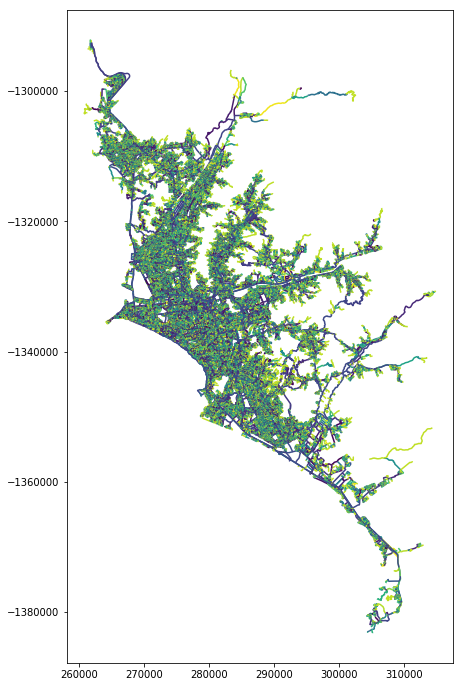

In [22]:
neew_gp.plot(column='edge_centr', cmap='viridis', figsize=[12,12])

## Tunis, Tunisia

In [ ]:
G_ = nx.read_gpickle('data/Tunis/Tunis')

%time edge_centrality = nx.edge_betweenness_centrality(G_)